#SVM Implementation Through sklearn

##Loading Necessary Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import math

##Loading dataset

In [12]:
df = pd.read_csv("Data.csv",index_col=0)
df.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


In [13]:
X = df.drop('TARGET CLASS', axis=1)
y = df['TARGET CLASS'] 

##Standardize the Variables

In [18]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler(with_mean=False)
scalar.fit(df.drop('TARGET CLASS',axis=1))
scaled_features = scalar.transform(df.drop('TARGET CLASS',axis=1))

In [19]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ
0,3.156987,4.522446,1.948971,3.291349,3.209576,1.377414,2.979315,2.228929,2.995403,6.032687
1,2.195693,3.906190,1.837088,3.597108,3.798365,2.533083,2.648469,3.509057,2.117071,7.312760
2,2.491826,4.675857,3.163913,3.727593,6.274905,2.815633,6.378085,3.997004,3.262628,6.298151
3,4.263369,5.396732,2.241003,3.597019,4.696033,3.418569,5.528474,4.777788,5.186447,5.649014
4,4.419804,3.696146,2.152583,2.914545,5.066099,2.749016,4.375048,2.238946,4.985894,6.952511


##Splitting data into train, test and cross validation set

In [20]:
X = scaled_features
y = df['TARGET CLASS']

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.2)

print('Total number of datapoints in the dataset:',X.shape[0])

print('Number of datapoints in Training data: {}({:.2f}%)'.
      format(X_tr.shape[0],(X_tr.shape[0]/X.shape[0])*100))

print('Number of datapoints in Cross Validation data: {}({:.2f}%)'.
      format(X_cv.shape[0],(X_cv.shape[0]/X.shape[0])*100))

print('Number of datapoints in Test Data: {}({:.2f}%)'.
      format(X_test.shape[0],(X_test.shape[0]/X.shape[0])*100))

Total number of datapoints in the dataset: 1000
Number of datapoints in Training data: 560(56.00%)
Number of datapoints in Cross Validation data: 140(14.00%)
Number of datapoints in Test Data: 300(30.00%)


##SVM model building along with hyperparameter tuning for the optimal 'alpha', using AUC value

- There are two versions of SVM:
  - Linear kernel SVM
  - RBF kernel SVM
- When we use Linear Kernel SVM, it is better to use SGDClassifier with hinge loss because it is computationally less expensive.
- When we use ‘SGDClassifier’ with hinge loss and try to find the AUC score, we would have to use CalibratedClassifierCV.

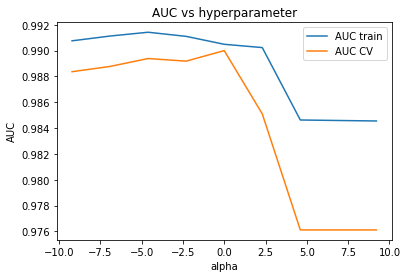

Optimal alpha for which auc is maximum :  1


In [23]:
#Using SGDClassifier with hinge loss for Linear Kernel SVM

auc_train=[]
auc_cv=[]

alpha = [10**-4, 10**-3,10**-2,10**-1,1,10,10**2,10**3,10**4]#alpha=1/C
for a in alpha:
    model=SGDClassifier(alpha=a) #loss default hinge
    svm=CalibratedClassifierCV(model, cv=3) #calibrated classifier cv for calculation of predic_proba
    svm.fit(X_tr,y_tr)
    probcv=svm.predict_proba(X_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=svm.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(y_tr,probtr))

optimal_alpha= alpha[auc_cv.index(max(auc_cv))]
alpha_log=[math.log(x) for x in alpha]#converting values of alpha into logarithm

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(alpha_log, auc_train, label='AUC train')
ax.plot(alpha_log, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
ax.legend()
plt.show()

print('Optimal alpha for which auc is maximum : ',optimal_alpha)

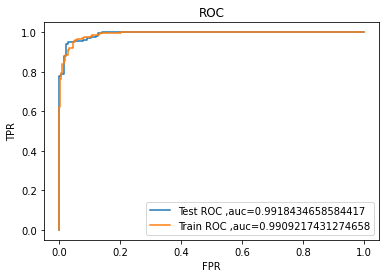

In [25]:
#Training our model for alpha=optimal_alpha
#ROC curve
model=SGDClassifier(alpha=optimal_alpha)
svm=CalibratedClassifierCV(model, cv=3)
svm.fit(X_tr,y_tr)
predi=svm.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=svm.predict_proba(X_tr)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_tr,pred)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_tr,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

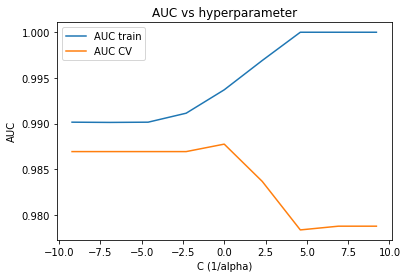

Optimal C for which auc is maximum :  1


In [29]:
#Using RBF Kernel SVM

C = [10**-4, 10**-3,10**-2,10**-1,1,10,10**2,10**3,10**4]#C=1/alpha
auc_train=[]
auc_cv=[]
for c in C:
    svm=SVC(C=c,probability=True)
    svm.fit(X_tr,y_tr)
    probcv=svm.predict_proba(X_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,probcv))
    probtr=svm.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(y_tr,probtr))
   
C_log=[math.log(x) for x in C]#converting values of C into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C_log, auc_train, label='AUC train')
ax.plot(C_log, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('C (1/alpha)')
plt.ylabel('AUC')
ax.legend()
plt.show()

optimal_c = C[auc_cv.index(max(auc_cv))]
print('Optimal C for which auc is maximum : ',optimal_c)

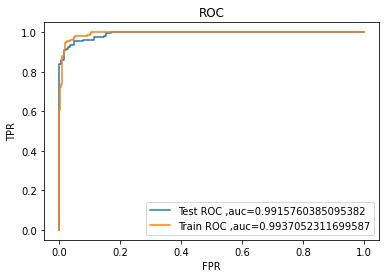

In [30]:
#training our model for c=optimal_c, alpha=1/c
svm=SVC(C=optimal_c,probability=True)
svm.fit(X_tr,y_tr)
predi=svm.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=svm.predict_proba(X_tr)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_tr,pred)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_tr,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

##Evaluation metrics

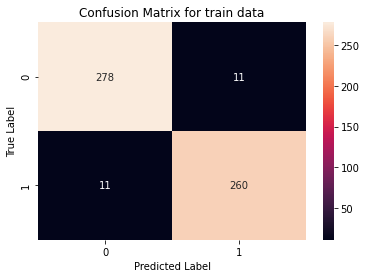



-------------------- Metric report for train data --------------------

               precision    recall  f1-score   support

           0       0.96      0.96      0.96       289
           1       0.96      0.96      0.96       271

    accuracy                           0.96       560
   macro avg       0.96      0.96      0.96       560
weighted avg       0.96      0.96      0.96       560



In [32]:
#Confusion matrix using heatmap for train data

predic=svm.predict(X_tr)

conf_mat = confusion_matrix(y_tr, predic)
class_label = ["0", "1"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for train data','-'*20)
print('\n',classification_report(y_tr,predic))

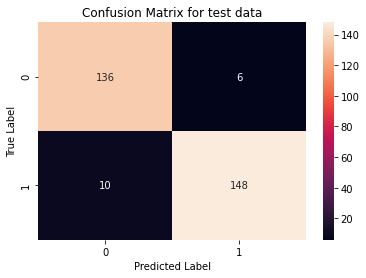



-------------------- Metric report for test data --------------------

               precision    recall  f1-score   support

           0       0.93      0.96      0.94       142
           1       0.96      0.94      0.95       158

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



In [33]:
#Confusion matrix using heatmap for test data

predic=svm.predict(X_test)

conf_mat = confusion_matrix(y_test, predic)
class_label = ["0", "1"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for test data','-'*20)
print('\n',classification_report(y_test,predic))